In [120]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 글꼴 경로 설정 (예: Malgun Gothic)
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 경우
font_prop = fm.FontProperties(fname=font_path, size=12)

# Matplotlib의 기본 글꼴 설정
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 표시 설정

# 고객 클러스터링
- 점수 및 items 개수로 클러스터링
- 어떤 기법을 사용할 것인지?

In [121]:
data = pl.scan_csv('data/CUSTOMER_SCORE_금리.csv')
data_suv_range = pl.scan_csv('data/surv_data_2030_range.csv')
data_suv_mean = pl.scan_csv('data/surv_data_2030_mean.csv')

In [122]:
data.collect_schema().names()

['고객ID',
 '기준년월',
 '연령대',
 '성별',
 '고객등급',
 '입출금예금',
 '기타예금',
 '비이자상품',
 '카드',
 '대출',
 '기준금리',
 '보유상품수',
 '거래기간(개월)',
 '총점수']

In [123]:
data_suv_mean = data_suv_mean.collect().to_pandas().drop(columns='고객ID').drop(data_suv_mean.columns[0], axis=1)
data_suv_range = data_suv_range.collect().to_pandas().drop(columns='고객ID').drop(data_suv_range.columns[0], axis=1)

C:\Users\campus3S031\AppData\Local\Temp\ipykernel_25152\925369057.py:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  data_suv_mean = data_suv_mean.collect().to_pandas().drop(columns='고객ID').drop(data_suv_mean.columns[0], axis=1)
C:\Users\campus3S031\AppData\Local\Temp\ipykernel_25152\925369057.py:2: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  data_suv_range = data_suv_range.collect().to_pandas().drop(columns='고객ID').drop(data_suv_range.columns[0], axis=1)


In [124]:
features = [
'입출금예금',
'기타예금',
'비이자상품',
'카드',
'대출',
'기준금리',
'보유상품수',
'거래기간(개월)',
'총점수'
]

In [125]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

def kmeans_clustering(data, n_clusters=5):
    """
    K-means 클러스터링 수행
    """
    # 스케일링
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # K-means 클러스터링
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    
    # 클러스터별 특성 분석
    cluster_means = []
    for i in range(n_clusters):
        cluster_data = data[clusters == i]
        cluster_means.append(cluster_data.mean())
    
    # 결과 시각화
    cluster_means_df = pd.DataFrame(cluster_means, 
                                  index=[f'Cluster {i}' for i in range(n_clusters)])
    
    plt.figure(figsize=(12, 6))
    cluster_means_df.plot(kind='bar')
    plt.title('클러스터별 평균 특성')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return clusters, cluster_means_df

<Figure size 1200x600 with 0 Axes>

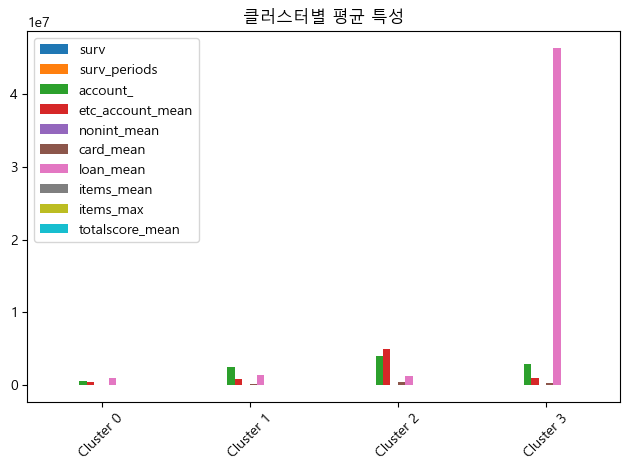

In [126]:
clusters, cluster_means = kmeans_clustering(data_suv_mean, 4)

<Figure size 1200x600 with 0 Axes>

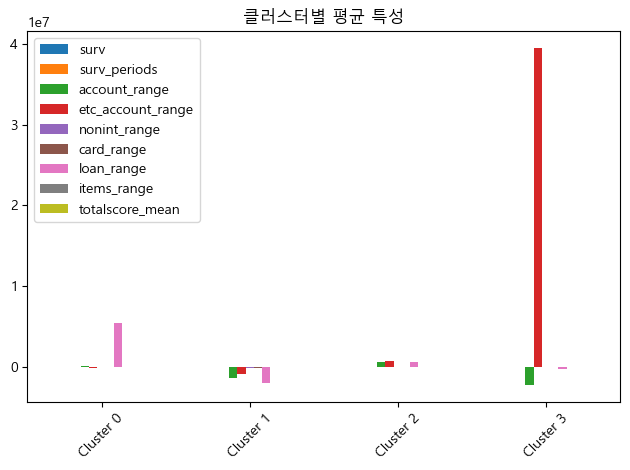

In [127]:
clusters, cluster_means = kmeans_clustering(data_suv_range, 4)

## EDA

In [129]:
tmp = data.group_by('고객ID').agg([
    pl.col('연령대').last()
]).collect()

In [130]:
tmp['연령대'].value_counts()

연령대,count
i64,u32
40,350403
20,298262
30,301233
10,111137
60,537579
50,380079
